# Calculating the $g(\theta)$ of the colloids in the SFD

In [1]:
import pandas as pd
import numpy as np
import scipy.spatial as spa
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
idx = pd.IndexSlice
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', size=15)

The $g(\theta)$ is defined as the probability of finding another particle at an angle $\theta$ from a particle.

# Define a common calculation function

### Definition of $\Delta \theta$

We define the angular distance $\Delta\theta$ as described in [SFD Report 1](https://nbviewer.jupyter.org/github/aortiza/Notes/blob/master/SingleFileDiffusion/Report%201%20-%20Mean%20Square%20Displacements.ipynb): 

$$\Delta\theta = 
\begin{cases}
\theta_{t+\delta t}-\theta_{t} & \left|\theta_{t+\delta t}-\theta_{t}\right|\leq\pi \\
sign\left(\theta_{t+\delta t}-\theta_{t}\right)\left[2\pi-\left(\theta_{t+\delta t}-\theta_{t}\right)\right] & \left|\theta_{t+\delta t}-\theta_{t}\right|> \pi\\
\end{cases}
$$

In [2]:
def angular_distance(theta1,theta2):
    """Takes two angles and returns the smallest difference between the two."""
    delta = theta1-theta2
    logical = np.abs(delta)>np.pi
    delta[logical] = np.sign(delta[logical])*2*np.pi-delta[logical]
    return delta

### Correlation function around a single particle

We'll first define the $g_i\left(\theta\right)$ as the probability of finding one particle within an angle $\theta+\delta\theta$ measured with respect to particle $i$. 

From Alejandro Villada's thesis:

$$ \int_0^{2\pi} g_i\left(\theta\right)\mathrm{d}\theta =\frac{N-1}{\rho}$$

where $\rho$ is the particle density in the circle $\rho = \frac{N}{2\pi}$. Since $g_i\left(\theta\right)$ is even, we can write.
$$ \int_0^{\pi} g_i\left(\theta\right)\mathrm{d}\theta =\pi\frac{N-1}{N}$$

We now define a discrete function $\bar g_i\left(j\Delta\theta\right)\approx g_i\left(\theta\right)$ where $j\in\mathbf{Z}$ and $j\in[0,n)$ and $\Delta\theta \equiv \frac{\pi}{n}$

This discrete function has to fulfill 
$$\bar g_i\left(j\Delta\theta\right) = A \mathcal{N(j\Delta\theta)} $$
where $\mathcal{N(j\Delta\theta)}$ is the number of particles found in the range $j<\frac{\theta}{\Delta\theta}<j+1$. In other words, $\mathcal{N(j\Delta\theta)}$ the histogram of the positions of the other particles in the range $[0,\pi)$ with $n$ bins. 

We can also write an approximate integral of the discrete function
$$  \sum_{j=0}^{n} \bar g_i\left(j\Delta\theta\right) \Delta\theta  = \pi\frac{N-1}{N}$$ 

and then in terms of $\mathcal{N(j\Delta\theta)}$
$$  A\sum_{j=0}^{n} \mathcal{N}\left(j\Delta\theta\right)   = n\frac{N-1}{N}$$ 


The sum of all the values of the histogram is given by the number of (other) particles $N-1$ times the number of counted frames $M$: 
$$\sum_{j=0}^{n} \mathcal{N}\left(j\Delta\theta\right) = M(N-1)$$

And therefore we can find a discrete correlation function  
$$\bar g_i\left(j\Delta\theta\right) = \frac{n}{NM} \mathcal{N(j\Delta\theta)} $$

We now define a function that calculates $\bar g_i\left(j\Delta\theta\right)$. Later we'll calculate this for each particle and take the average.

In [26]:
def single_particle_correlation(trajectory,particle,bins):
    """ Returns the probability of finding a particle at a given angle from particle `particle`. 
    Uses angular_distance to define $\Delta\Theta$"""
    
    """M is the number of frames, N is the number of particles"""
    M = len(trajectory.index.get_level_values("frame").unique())
    N = len(trajectory.index.get_level_values("id").unique())
    n = len(bins)
    """ Calculate distance from current particle to all particles for each frame"""
    delta_theta = angular_distance(trajectory,trajectory.loc[idx[:,particle]])
    
    """ Drop all the self distances """
    delta_theta = abs(delta_theta.drop(particle,level='id')) 
    """ For some reason, there is NaN. Drop them."""
    delta_theta = delta_theta.dropna()

    normalization = n/(M*N)
    
    """Calculate histogram"""
    H,bins = np.histogram(delta_theta.values, bins = bins)
    
    return H*normalization

### Calculate $g(\theta)$ for each particle and average. 
Return the result in a pandas DataFrame

In [27]:
def calculate_g_of_theta(trajectory, bins = None, col_name = ""):
    """ Uses single_particle_correlation to calculate g(theta) for each particle in trajectory. 
    Averages and returns them in a pandas DataFrame"""
    trajectory["theta"] = np.arctan2(trajectory.x,trajectory.y)
    trajectory = trajectory.theta

    if bins is None:
        bins = np.linspace(0,np.pi,100)

    H = np.mean(
        np.array(
            [single_particle_correlation(trajectory,i,bins) 
             for i in tqdm_notebook(trajectory.index.get_level_values("id").unique())]),
        axis=0)


    g_of_theta = pd.DataFrame(data=H,index=(bins[0:-1]+bins[1:])/2,columns=[col_name])

    g_of_theta.index.name="theta"

    return g_of_theta

# Load Experiments and calculate correlation function

C:\ProgramFiles\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


A Jupyter Widget

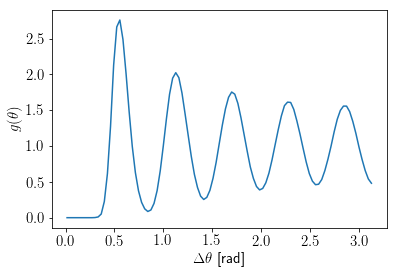

In [28]:
trajectory = pd.read_csv("D:/Experiment1_avi/Experiment1_2018_07_25_09_22_27_trj.dat",sep="\t",index_col=[0,1])

g_of_theta = calculate_g_of_theta(trajectory, bins = np.linspace(0,np.pi,100), col_name = "Exp_1")

plt.plot(g_of_theta)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")

C:\ProgramFiles\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


A Jupyter Widget

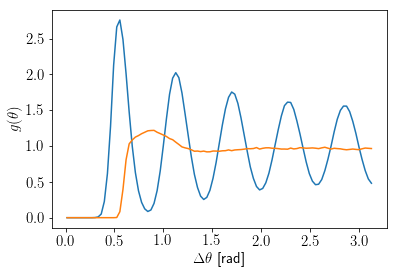

In [29]:
trajectory = pd.read_csv("D:/Experiment8_avi/Experiment8_2018_09_17_16_58_33_trj.dat",
                         sep="\t",index_col=[0,1])

g_of_theta = pd.concat([g_of_theta,
                        calculate_g_of_theta(trajectory, bins = np.linspace(0,np.pi,100), col_name = "Exp_8")],
                       axis=1)

plt.plot(g_of_theta)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")

C:\ProgramFiles\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


A Jupyter Widget

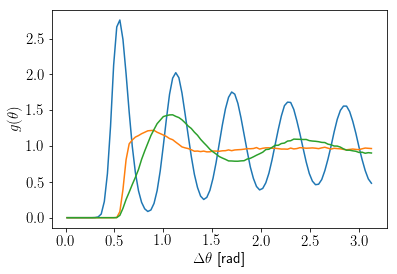

In [30]:
trajectory = pd.read_csv("D:/Experiment9_avi/Experiment9_2018_09_21_15_37_26_trj1.dat",
                         sep="\t",index_col=[0,1])

g_of_theta = pd.concat([g_of_theta,
                        calculate_g_of_theta(trajectory, bins = np.linspace(0,np.pi,100), col_name = "Exp_9")],
                       axis=1)
plt.plot(g_of_theta)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")

C:\ProgramFiles\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


A Jupyter Widget

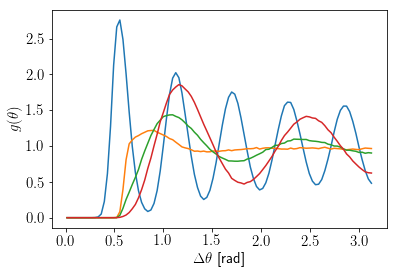

In [31]:
trajectory = pd.read_csv("D:/Experiment10_avi/Experiment10_2018_09_25_10_39_13_trj.dat",
                         sep="\t",index_col=[0,1])

g_of_theta = pd.concat([g_of_theta,
                        calculate_g_of_theta(trajectory, bins = np.linspace(0,np.pi,100), col_name = "Exp_9")],
                       axis=1)
plt.plot(g_of_theta)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")

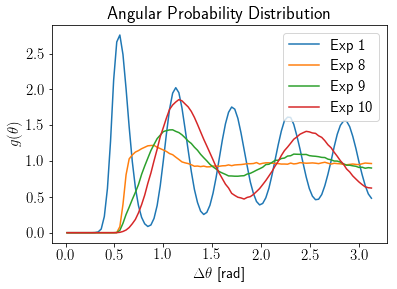

In [32]:
plt.plot(g_of_theta)
plt.xlabel(r"$\Delta \theta$ [rad]")
plt.ylabel(r"$g(\theta)$")
plt.legend(["Exp 1","Exp 8","Exp 9","Exp 10"],loc=1)
plt.title("Angular Probability Distribution");

In [33]:
g_of_theta.to_csv("C:/Users/aortiza/Desktop/g_of_theta.dat",sep="\t")

## Check Normalization

The integral of the $g(\theta)$ should be approximatelly equal to $\pi\frac{N-1}{N}$

In [62]:
"""N is the number of particles of the different experiments"""
N = np.array([11,5,5,5])
np.pi*(N-1)/N

array([ 2.85599332,  2.51327412,  2.51327412,  2.51327412])

In [63]:
(g_of_theta*np.mean(np.diff(g_of_theta.index))).sum()

Exp_1    2.880166
Exp_8    2.538639
Exp_9    2.538592
Exp_9    2.538559
dtype: float64